# 0.0. Planejamento
##  Input
### Dados: 
* **Id**: Identificador Único;
* **Title**: Título da vaga;
* **FullDescription**: Texto completo com a descrição da vaga;
* **LocationRaw**: Texto cru da localizacao da vaga;
* **LocationNormalized**: Localizacao normalizada - **Carrega erro**;
* **ContractType**: Tipo de contrato. Indica como é o regime de horas da vaga. Pode ser:
    * full_time;
    * part_time.
* **ContractTime**: Tempo de validade do contrato. Pode ser:
    * permanent;
    * contract.
* **Company**: Nome da compania que está contratanto;
* **Category**: 30 categorias de trabalho - **Carrega erro**;
* **SalaryNormalised**: Salario anualizado da vaga. O que estamos buscando prever;
* **SourceName**: Nome to site o qual recebemos a vaga.

### Problema:
* Temos um conjunto de dados com as informacoes de vagas abertas. Com base nessas \
informacoes, devemos criar um algoritmo capaz de prever o salário em novas vagas.

## Output
* **Modelo**: Um modelo capaz de prever o salario de novos usuarios;
* **WebApp**: Um webapp que carregue esse modelo e faça previsões;
* **EDA**: Uma Análise Exploratória dos Dados e do Modelo:
    - Relatório do Modelo;
    - Relatório do Projeto.


## Tasks
1. Planejamento;
2. Ciclos;
3. Construcao do Modelo Final;
    - Métrica Principal: Mean Absolute Error (MAE)

# 1.0. Imports

In [1]:
# api
import requests

# Data Manipulation
import pandas as pd
import numpy as np

# Data Plot
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import HTML
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from xgboost import XGBRegressor

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# stats
from scipy.stats import pointbiserialr

import pickle

[nltk_data] Downloading package punkt to /home/tadeu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tadeu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tadeu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1.1. Helper Functions

In [2]:
def jupyter_settings():
    """
    Retorna algumas configuracoes para o jupyter notebook
    """
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    


def cross_val_performance(X_train, y_train, model, cv):
    """
    Retorna algumas o RMSE, MAE e MAPE em cross validation do modelo
    Input:
        X_train: os dados de treino
        y_train: A variavel resposta
        model: modelo a ser usado
        cv: numero de folds
    Output:
        Retorna um dataframe com as metricas de RMSE, MAE, MAPE e o tempo
        médio de processamento.
    """
    # Cross Val Train
    results = cross_validate(model, 
                             X_train, 
                             y_train, 
                             cv=cv,
                             scoring=[
                                 'neg_mean_absolute_error', 
                                 'neg_mean_absolute_percentage_error', 
                                 'neg_root_mean_squared_error'
                             ]
                            )
    
    # Performance
    mae = round(np.mean(results['test_neg_mean_absolute_error'] * -1), 2)
    mape = round(np.mean(results['test_neg_mean_absolute_percentage_error'] * -1), 4)
    rmse = round(np.mean(results['test_neg_root_mean_squared_error'] * -1), 2)
    time = round(np.mean(results['fit_time']), 2)
    
    df_results = pd.DataFrame(
                {
                    'Modelo': type(model).__name__,
                    'MAE': mae,
                    'MAPE': mape,
                    'RMSE': rmse,
                    'time': time
                },
                index=[0]
            )
    
    return df_results


def baseline_performance(y_train, n_splits):
    """
    Return a cross validation metric from the baseline model - mean
    Input:
        y_train: array with train response variables
        n_splits: number of folds
    """
    kf = KFold(n_splits=n_splits)
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for train_index, valid_index in kf.split(y_train): # split index train - valid
        
        new_y_train = y_train.iloc[train_index]
        new_y_valid = y_train.iloc[valid_index]
        
        y_hat = np.repeat(new_y_train.mean(), len(new_y_valid))
        
        mae_list.append(mean_absolute_error(new_y_valid, y_hat))
        mape_list.append(mean_absolute_percentage_error(new_y_valid, y_hat))
        rmse_list.append(sqrt(mean_squared_error(new_y_valid, y_hat)))
        
    df_results = pd.DataFrame(
                {
                    'Modelo': 'Baseline',
                    'MAE': round(np.mean(mae_list), 3),
                    'MAPE': round(np.mean(mape_list), 3),
                    'RMSE': round(np.mean(rmse_list), 3),
                    'time': 0
                },
                index=[0]
            )
    
    return df_results


def tokenize(text, perm=False):
    # normalize case and remove punctuation
    if perm:
        text = re.sub(r"[^a-zA-Z0-9-]", " ", text.lower())
    else:
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words and remove single letters:
    tokens = [lemmatizer.lemmatize(word) for word in tokens if (word not in stop_words) and (len(word) >= 2)]

    return tokens


def comparison_continuos(df=[], names=[]):
    
    for i, dataframe in enumerate(df):
        n_df = dataframe.describe()
        n_df.loc['skew'] = dataframe.skew()
        n_df.loc['kurtosis'] = dataframe.kurtosis()
        
        n_df.name = names[i]
        
        if i == 0:
            final_df = n_df
        else:
            final_df = pd.concat([final_df, n_df], axis=1)
        
    return final_df


def city_imputation(df, column_city_raw, column_city_normalized, list_city):
    """
    Retorna uma series com as cidades extraidas da api e seu index de referencia
    Input:
        df - Dataframe usado
        column_city_raw - Coluna raw de cidades
        column_city_normalized - Coluna normaliada de cidades
        list_city = lista de cidades da api
    Output:
        Series com cada index associado a sua cidade extraida da referencia da api
        ou do coalesce com a coluna normalizada original
    """    
    
    df_aux = df.loc[:, [column_city_raw, column_city_normalized]]
    
    # For loop por cada cidade na lista da api
    for city in list_city:

        df_aux['aux'] = df_aux['LocationRaw'].apply(lambda x: city if city.lower() in x.lower() else None)
        index_val = df_aux.loc[df_aux['aux'] == city, :].index.values

        for num_index in index_val:
            dict_values[num_index] = city
            
    # Criando um DataFrame com as cidades e index
    new_city = pd.DataFrame(dict_values, index=['City']).T

    # Merge com as cidades originais
    merge_city = pd.merge(df_aux, new_city, left_index=True, right_index=True, how='left').loc[:, ['LocationNormalized', 'City']]

    # Coalesce ente as colunas
    city_series = merge_city['City'].combine_first(merge_city['LocationNormalized'])

    return city_series

In [3]:
class TransformText():
    """
    Classe usada para transformar uma coluna de textos em dummies de palavras
    e extrair informacoes relevantes como:
        1. A frequencia de cada palavra;
        2. A correlacao da palavra com a variavel resposta;
        3. O p_value dessa correlacao.
    
    Attributes:
        dataframe (dataframe pandas) - dataframe a ser utilizado para treino;
        text_col (str) - nome da coluna contendo texto;
        response_col (str) - nome da coluna com a variavle resposta continua.
        
    OBS:
        Por ser um protótipo, essa classe segue alguns preceitos desse projeto 
        especifico:
            1. Necessita de uma variavel resposta;
            2. Essa variavel resposta tem que ser continua.
    """
    
    def __init__(self, df, text_col='', response_col=''):
        
        self.text_name = text_col
        self.response_name = response_col
        self.dataframe = df.loc[:, [self.text_name, self.response_name]]
    

    def unique_tokenize(self, text):
        """
        Funcao utilizada para aplicar o processo de tokenizacao de um texto
        Input:
            text: Texto que sera tokenizado
        Output:
            uma lista de palavras que passam pelas seguintes etapas:
                1. Sao selecionados apenas valores a-zA-Z0-9;
                2. Todo é colocado em minusculo;
                3. O texto é tokenizado com word_tokenize;
                4. o texto é lemmatizado e as stop_words sao retiradas;
                5. Apenas valores com tamanho maior que 2 sao selecionados.
        """
        
        # normalize case and remove punctuation
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

        # tokenize text
        tokens = word_tokenize(text)

        # lemmatize andremove stop words and remove single letters:
        tokens = [
            lemmatizer.lemmatize(word) 
            for word 
            in tokens 
            if (word not in stop_words) 
            and (len(word) >= 2)
        ]
        
        return tokens
        
        
    def tokenize(self):
        """
        Funcao utilizada para aplicar a funcao unique_tokenize em todas as 
        linhas de text_name e guardar em self.tokens
        """
        self.tokens = self.dataframe[self.text_name].apply(lambda x: self.unique_tokenize(x))
        
        return self.tokens
    
    
    def get_frequency(self):
        """
        Retorna a frequencia absoluta de cada palavra em text_name
        """
        # gerando o dataframe com as contagens
        final_df = self.tokenize().explode().value_counts().reset_index().rename({'index': 'Word',
                                                                                  self.text_name: 'Count'},
                                                                                 axis=1)
        
        self.frequency_ = final_df.sort_values(by='Count', ascending=False)
        
        return self.frequency_

    
    def unique_words(self, sample_size):
        """
        Gera uma lsita das palavras unicas de acordo com o tamanho desejado
        Input:
            sample_size (int64) - quantas linhas quero retornar.
        Output:
            Retorna uma lista com os valores unicos mais frequentes na ordem
            de grandeza de sample_size.
        """        
        
        return self.get_frequency().head(sample_size)['Word'].unique()
        
    

    def get_corr(self, sample_size):
        """
        Faz o calculo de correlacao utilizando o metodo pointbiserial
        Input:
            sample_size (int64) - sample_size para contar o numero de palavras
            desejadas em unique_words
        Output:
            Um DataFrame com as seguintes colunas:
                Word - A palavra utilizada;
                Corr - A correlacao entre a palavra e a variável resposta;
                p-value - o p-value dessa correlacao.
        """
        dict_words = {} # dicionario a ser alimentado
        
        list_words = self.unique_words(sample_size) # chamando a funcao com limite de palavras
        array_x = self.tokens # determinadno o array com os tokens
        array_y = self.dataframe[self.response_name].values # determinando o array com a var resposta
        
        for word in list_words: # iterando por cada palavra selecionada
            
            # se a palavra estiver no texto, atribui-se 1, senao atribui-se 0
            list_values = [1 if word in row else 0 for row in array_x] 
            # calculando a correlacao através do método do ponto bisserial
            result = pointbiserialr(list_values, self.dataframe[self.response_name].values)
            
            dict_words[word] = [result[0], result[1]]
            
        self.corr_ = pd.DataFrame(dict_words, index=['Corr', 'p-value']).T.sort_values(by='Corr')

        return self.corr_


    def transform(self, sample_size, threshold=0.0):
        """
        gera um DataFrame com cada palavra sendo uma coluna sendo que:
            1 -> a palavra esta no texto;
            2 -> a palavra nao esta no texto.
        Input:
            sample_size (int64) - o numero de palavras em unique_words;
            theshold (float64) - a correlacao minima de uma palavra para ser considerada.
        """

        # transformando as correlacoes em valores absolutos
        df_cor = self.get_corr(sample_size).apply(lambda x: abs(x))

        # Colunas que serao usadas
        selected_cols = df_cor.loc[df_cor['Corr'] > threshold, :].index.to_list()
        
        self.list_words = selected_cols
        
        df_text = pd.DataFrame(self.tokens)
        
        # imputando as colunas
        for col in selected_cols:
            coluna = pd.Series(df_text[self.text_name].apply(lambda x: 1 if col in x else 0,), name=col,index=df_text.index.to_list())
            df_text = pd.concat([df_text, coluna], axis=1)
            
        self.dummy_cols_ = df_text.drop([self.text_name], axis=1)
        
    
    def get_all(self):
        """
        Retorna:
            df_corr_freq: dataframe com a frequencia, correlacao e p_value de cada palavra;
            dummy_cols: dataframe com as colunas dummy.
        """
        
        df_corr_freq = pd.merge(self.frequency_, self.corr_, left_on='Word', right_index=True)
        
        return df_corr_freq, self.dummy_cols_

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.2. Data

In [5]:
data_import = pd.read_csv('../data/Train_rev1.csv')

data_import.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


# 2.0. Data Description

In [6]:
df2 = data_import.copy()

## 2.1. Shape Data

In [7]:
print(f'Rows: {df2.shape[0]}')
print(f'Columns: {df2.shape[1]}')

Rows: 244768
Columns: 12


## 2.2. Data Types

In [8]:
df2.dtypes

Id                     int64
Title                 object
FullDescription       object
LocationRaw           object
LocationNormalized    object
ContractType          object
ContractTime          object
Company               object
Category              object
SalaryRaw             object
SalaryNormalized       int64
SourceName            object
dtype: object

## 2.3. Check Na


In [9]:
tot_na = df2.isnull().sum()
percentage_na = round(df2.isnull().mean(), 4) * 100

# dataframe of na
pd.DataFrame([tot_na, percentage_na], index=['Total', 'Percentual']).T

,Total,Percentual
Id,0.0,0.00
Title,1.0,0.00
FullDescription,0.0,0.00
LocationRaw,0.0,0.00
LocationNormalized,0.0,0.00
ContractType,179326.0,73.26
ContractTime,63905.0,26.11
Company,32430.0,13.25
Category,0.0,0.00
SalaryRaw,0.0,0.00


# 3.0. Variable Filtering + Split

In [37]:
df3 = df2.copy()

In [38]:
df3.drop(['Id', 'SalaryRaw', 'SourceName', 'Company'], axis=1, inplace=True)
df3.dropna(subset=['Title'], axis=0, inplace=True)

## 3.1. Split Dataset

In [39]:
y = df3.loc[:, 'SalaryNormalized']
X = df3.drop('SalaryNormalized', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4.0. Feature Engineering

In [40]:
# X_train merge with y
X_train = pd.merge(X_train, y_train, right_index=True, left_index=True)

In [14]:
# list de stop_words
stop_words = stopwords.words("english")

# instanciando o lemmatizer
lemmatizer = WordNetLemmatizer()

## 4.1. Title - Salvo

In [15]:
## instanciando a classe TransformText()
#transf_title = TransformText(df=X_train, text_col='Title', response_col='SalaryNormalized')
#
## transformando as colunas
#transf_title.transform(sample_size=2000, threshold=0.02)
#
## recebendo as informacoes: Count, Corr e p-value | colunas dummys
#df_infos_title, dummy_cols_title = transf_title.get_all()

In [16]:
## save df's in csv file
#dummy_cols_title.to_csv('../data/dummy_cols_title.csv')
#df_infos_title.to_csv('../data/df_infos_title.csv')

## 4.2. Full Description - Salvo & Retirado C03

In [17]:
## instanciando a classe TransformText()
#transf_desc = TransformText(df=X_train, text_col='FullDescription', response_col='SalaryNormalized')
#
## transformando as colunas
#transf_desc.transform(sample_size=2000, threshold=0.02)
#
## recebendo as informacoes: Count, Corr e p-value | colunas dummys
#df_infos_desc, dummy_cols_desc = transf_desc.get_all()

In [18]:
## save df's in csv file
#df_infos_desc.to_csv('../data/df_infos_desc.csv')
#dummy_cols_desc.to_csv('../data/dummy_cols_desc.csv')

## 4.3. SourceName - Retirado C04

In [19]:
#a = X_train['SourceName']
#
#array_y = y_train.values
#
#dict_results = {}
#
#for column in source_dummies.columns:
#    array_x = source_dummies[column].values
#    
#    result = pointbiserialr(array_x, array_y)
#    
#    dict_results[column] = [result[0], result[1]]
#    
#source_dummies = pd.get_dummies(a)
#
#df = pd.DataFrame(dict_results, index=['Corr', 'p-value']).T
#
#df['Corr_abs'] = df['Corr'].apply(lambda x: abs(x))
#
#df_sorted = df.sort_values('Corr_abs', ascending=False)
#
#dummies_source = source_dummies.loc[:, df_sorted[df_sorted['Corr_abs'] >= 0.15].index]

## 4.4. Company - Retirado C04

In [20]:
#dum = pd.get_dummies(X_train['Company'])
#
#array_y = y_train.values
#
#dict_results = {}
#
#for column in dum.columns:
#    array_x = dum[column].values
#    
#    result = pointbiserialr(array_x, array_y)
#    
#    dict_results[column] = [result[0], result[1]]
#    
#df = pd.DataFrame(dict_results, index=['Corr', 'p-value']).T

## 4.5. Location

In [44]:
# Gerando um DataFrame auxiliar
dummies_city = X_train.loc[:, ['LocationRaw', 'LocationNormalized']]

In [45]:
# Fazendo uma requisicao na api para pegar as cidades de UK

url = 'https://countriesnow.space/api/v0.1/countries/cities'
myobj = {
    "country": "United Kingdom"
}

x = requests.post(url, data = myobj)

In [46]:
# Lista das cidades da API
city_api_list = pd.Series(x.json()['data']).to_list()

# Criando um Dicionario que associa o index com cada cidade
dict_values = {}

In [47]:
#column_new_city = city_imputation(X_train, 'LocationRaw', 'LocationNormalized', city_api_list)
#
## Salvando a series
#column_new_city.to_csv('../data/new_location.csv')

In [48]:
# Importando o csv
columns_city = pd.read_csv('../data/new_location.csv', index_col=0)

# Merge com os dados originais
X_train = pd.merge(X_train, columns_city, left_index=True, right_index=True)

# Excluindo a coluna original
X_train = X_train.drop('LocationNormalized', axis=1)

In [49]:
# Atribuindo nomes a Londres
X_train['City'] = X_train['City'].apply(lambda x: 'London' if 'London' in x else x)

In [50]:
# Teste de correlacao
dum = pd.get_dummies(X_train['City'])

array_y = y_train.values

dict_results = {}

for column in dum.columns:
    array_x = dum[column].values
    
    result = pointbiserialr(array_x, array_y)
    
    dict_results[column] = [result[0], result[1]]
    
df = pd.DataFrame(dict_results, index=['Corr', 'p-value']).T

In [140]:
df_corr = df.sort_values(by='Corr', ascending=False)

In [145]:
list_corr_city = df_corr.head(5).index.to_list()

In [146]:
df_aux = X_train.loc[:, ['City', 'LocationRaw']]

for column in list_corr_city:
    df_aux[column] = df_aux['City'].apply(lambda x: 1 if column == x else 0)

dummies_city = df_aux.drop(['City', 'LocationRaw'], axis=1)

# 5.0. Exploratory Data Analysis

In [147]:
color_blue = '#5975a4'
color_red = '#CD5C5C'

## 5.1. Response Variable - SalaryNormalized

### 5.1.1. Distribuicao

A Variável Resposta é **Distribuicao Normal Assimétrica a Direita**
- Média > Mediana

In [148]:
comparison_continuos([y_train], ['Normal'])

count       195813.000000
mean         34127.684669
std          17641.439316
min           5000.000000
25%          21500.000000
50%          30000.000000
75%          42500.000000
max         200000.000000
skew             1.405419
kurtosis         2.947614
Name: Normal, dtype: float64

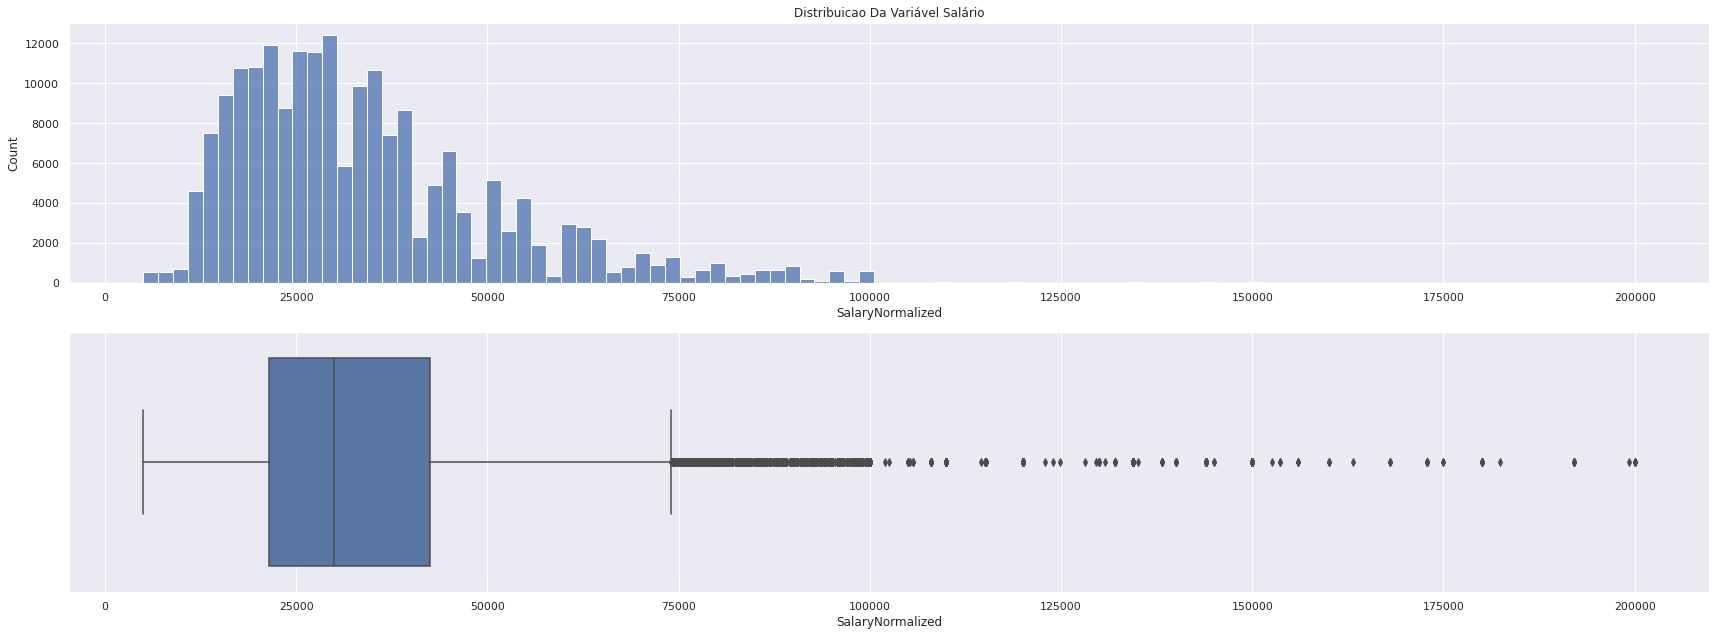

In [149]:
fig, ax = plt.subplots(2, 1)

# plot histogram
sns.histplot(y_train, ax=ax[0], bins=100)

# plot boxplot
sns.boxplot(x=y_train, ax=ax[1])

# title
ax[0].title.set_text('Distribuicao Da Variável Salário')

fig.tight_layout()

### 5.1.2. Outliers

**Método do Intervalo Interquartil para a idenficicacao de Outliers:**   

IQR = Q3 - Q1  

High Outlier = Q3 + (1.5 * IQR)  

**Limite Superior**: 74.000

**Dois testes a serem Feitos em Pŕoximo Ciclo:**  
    * Retirar valores acima de 100k  
    * Retirar valores acima de 74k  

In [150]:
# Calculo de outliers superiores - Nossos dados nao possuem outliers inferiores
high_outlier = y_train.quantile([0.75]) + (y_train.quantile([0.75]).values - y_train.quantile([0.25]).values) * 1.5

print(f'Limite Superior - Outliers: {high_outlier.values[0]}')

Limite Superior - Outliers: 74000.0


In [151]:
y_outliers = y_train[y_train > 74000]

print(f'% de Entradas maiores que 74.000: {round((len(y_outliers) / len(y_train) * 100), 2)}%')
print(f'% de Entradas maiores que 100.000: {round((len(y_outliers[y_outliers>100000]) / len(y_train) * 100), 2)}%')

% de Entradas maiores que 74.000: 4.01%
% de Entradas maiores que 100.000: 0.12%


<AxesSubplot:>

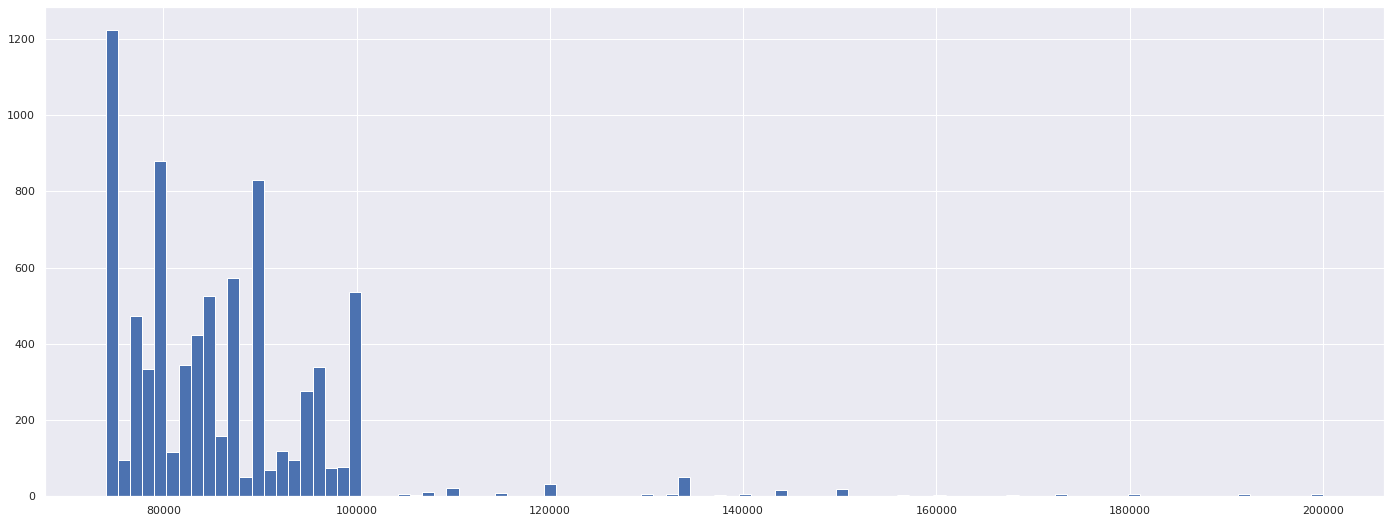

In [152]:
y_outliers.hist(bins=100)

## 5.2. ContractType

**Null Values**:
* Os valores de NA possuem uma distribuicao bem semelhante ao Contract_Full:
    * Podemos ajustar a premissa de que se na descricao nao se especifica   
    o tipo de contrato, está implítico que é full_time.
    * Realizar um teste de hipotese para confirmar isso no próximo ciclo.
    
**Distribuicao**:
* Como é de se esperar, contratos de meio período indicam um menor salario

In [153]:
# Select data
contract_null = df2.loc[df2['ContractType'].isnull(), 'SalaryNormalized']
contract_full = df2.loc[df2['ContractType'] == 'full_time', 'SalaryNormalized']            
contract_part = df2.loc[df2['ContractType'] == 'part_time', 'SalaryNormalized']      

In [154]:
comparison_continuos([y_train, contract_null, contract_full, contract_part], 
                     ['Normal', 'Contract_null', 'Contract_full', 'Contract_part'])

,Normal,Contract_null,Contract_full,Contract_part
count,195813.000000,179326.000000,57538.000000,7904.000000
mean,34127.684669,35586.723414,31601.048385,19259.765056
std,17641.439316,17850.454033,16293.629381,12614.238776
min,5000.000000,5000.000000,5000.000000,5000.000000
25%,21500.000000,22500.000000,20000.000000,12480.000000
50%,30000.000000,31500.000000,28000.000000,14880.000000
75%,42500.000000,45000.000000,38400.000000,21120.000000
max,200000.000000,200000.000000,199680.000000,192000.000000
skew,1.405419,1.375132,1.555401,3.732797
kurtosis,2.947614,2.811762,4.021242,24.267976


Text(0.5, 1.0, 'Contagem de Valores ContractType')

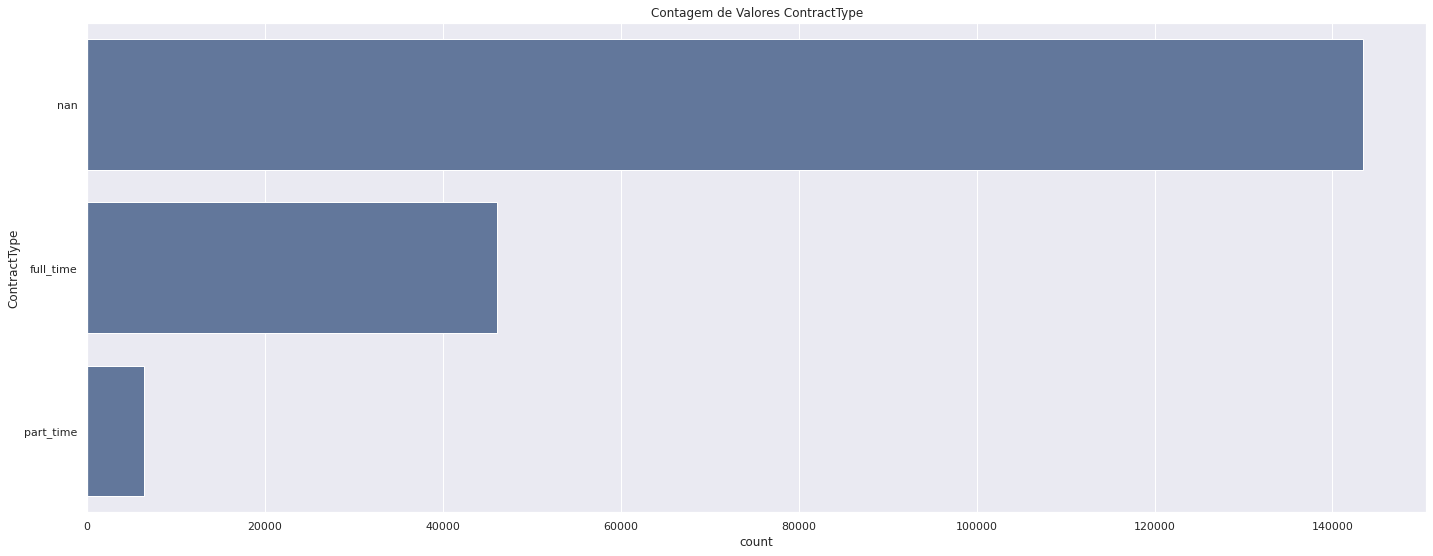

In [155]:
# plot
sns.countplot(y=X_train['ContractType'].apply(lambda x: str(x)), 
              order=['nan', 'full_time', 'part_time'], 
              color=color_blue)

# title
plt.title('Contagem de Valores ContractType')

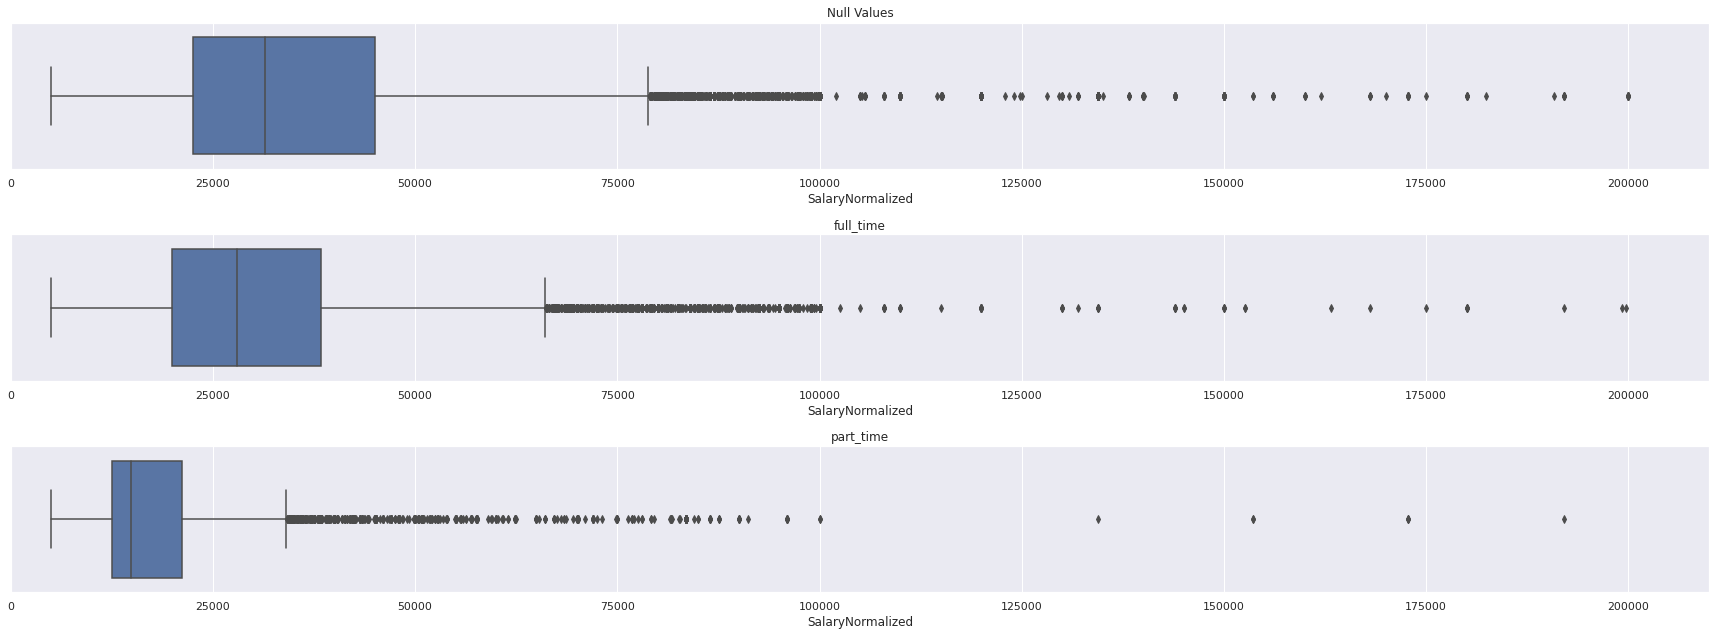

In [156]:
fig, ax = plt.subplots(3, 1)

# plots
sns.boxplot(x=contract_null, ax=ax[0])
sns.boxplot(x=contract_full, ax=ax[1])
sns.boxplot(x=contract_part, ax=ax[2])

# Titles
ax[0].title.set_text('Null Values')
ax[1].title.set_text('full_time')
ax[2].title.set_text('part_time')

# Colocando os eixos em mesma ordem
for value in range(0, 3):
    ax[value].set_xlim([0, 210000])

fig.tight_layout()

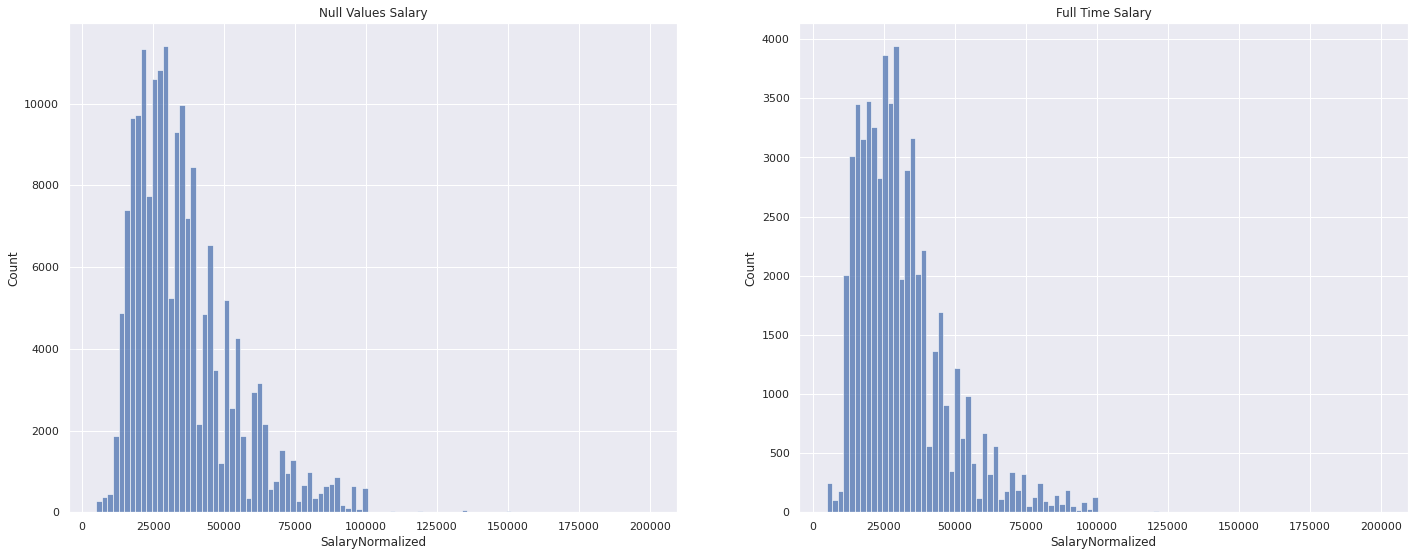

In [157]:
fig, ax = plt.subplots(1, 2)

# plots
sns.histplot(x=contract_null, ax=ax[0], bins=100)
sns.histplot(x=contract_full, ax=ax[1], bins=100)

# title
ax[0].title.set_text('Null Values Salary')
ax[1].title.set_text('Full Time Salary')

## 5.3. ContractTime
**Null Values**:
* Um quantidade consideravel de Null Values;

**Distribuicao**:
* A distribuicao dos 3 tipos sao bem semelhantes

In [158]:
# select data
null = df2.loc[df2['ContractTime'].isnull(), 'SalaryNormalized']
contract = df2.loc[df2['ContractTime'] == 'contract', 'SalaryNormalized']            
permanent =  df2.loc[df2['ContractTime'] == 'permanent', 'SalaryNormalized']      

In [159]:
comparison_continuos([y_train, null, contract, contract], 
                     ['Normal', 'Null', 'Contract', 'Contract'])

,Normal,Null,Contract,Contract
count,195813.000000,63905.000000,29342.000000,29342.000000
mean,34127.684669,30189.156107,36274.116079,36274.116079
std,17641.439316,17593.270422,22621.070725,22621.070725
min,5000.000000,5000.000000,5000.000000,5000.000000
25%,21500.000000,17280.000000,19200.000000,19200.000000
50%,30000.000000,25000.000000,30000.000000,30000.000000
75%,42500.000000,37500.000000,46080.000000,46080.000000
max,200000.000000,200000.000000,192000.000000,192000.000000
skew,1.405419,1.577114,1.418060,1.418060
kurtosis,2.947614,3.488568,2.264743,2.264743


Text(0.5, 1.0, 'Contagem de Valores ContractType')

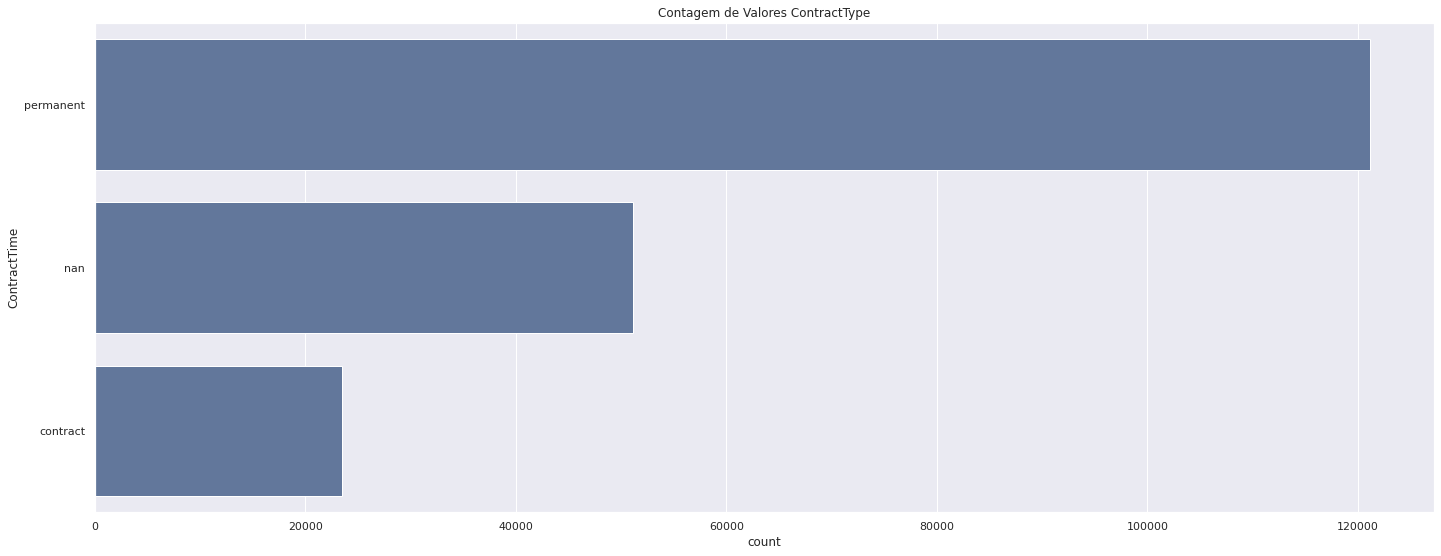

In [160]:
# plot
sns.countplot(y=X_train['ContractTime'].apply(lambda x: str(x)), 
              order=['permanent', 'nan', 'contract'], 
              color=color_blue)

# title
plt.title('Contagem de Valores ContractType')

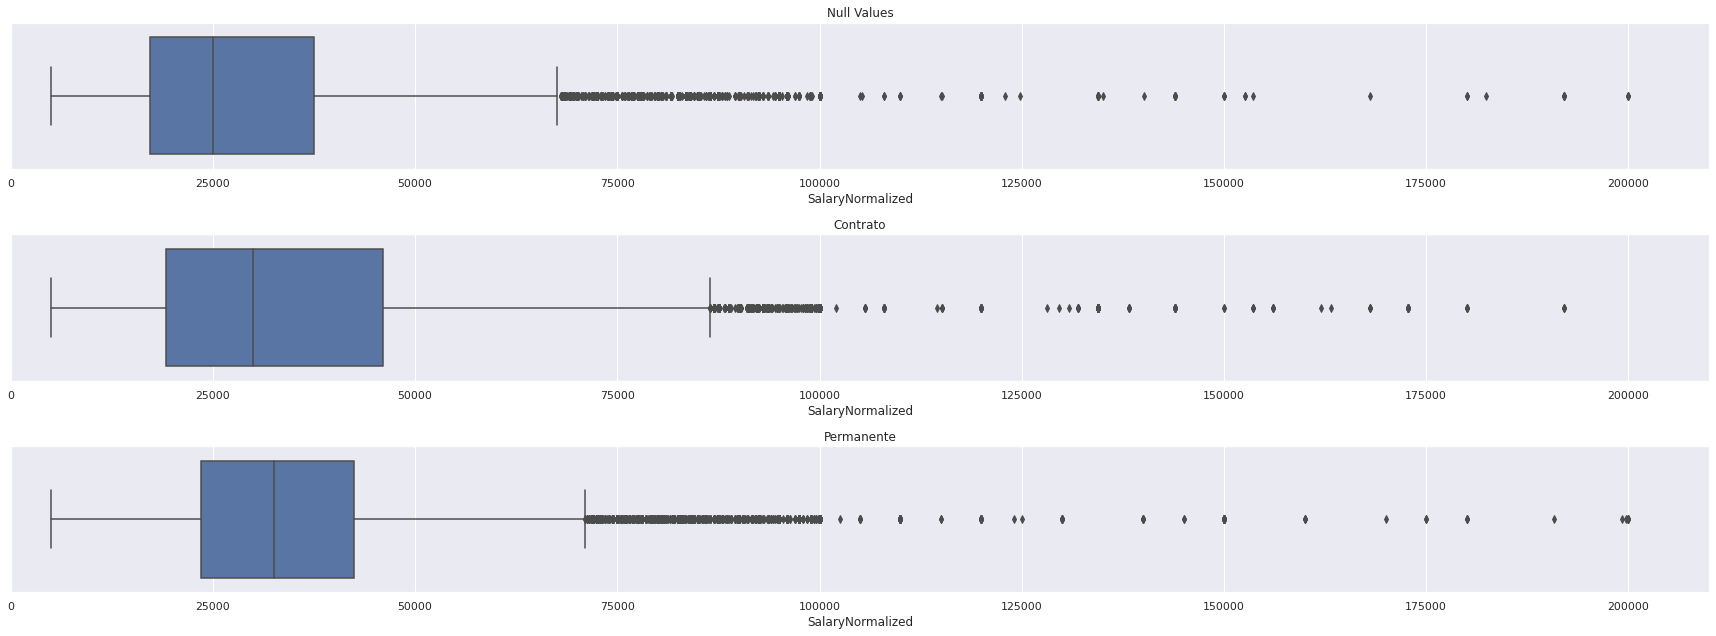

In [161]:
fig, ax = plt.subplots(3, 1)

# plots
sns.boxplot(x=null, ax=ax[0])
sns.boxplot(x=contract, ax=ax[1])
sns.boxplot(x=permanent, ax=ax[2])

# Titles
ax[0].title.set_text('Null Values')
ax[1].title.set_text('Contrato')
ax[2].title.set_text('Permanente')

# Colocando os eixos em mesma ordem
for value in range(0, 3):
    ax[value].set_xlim([0, 210000])

fig.tight_layout()

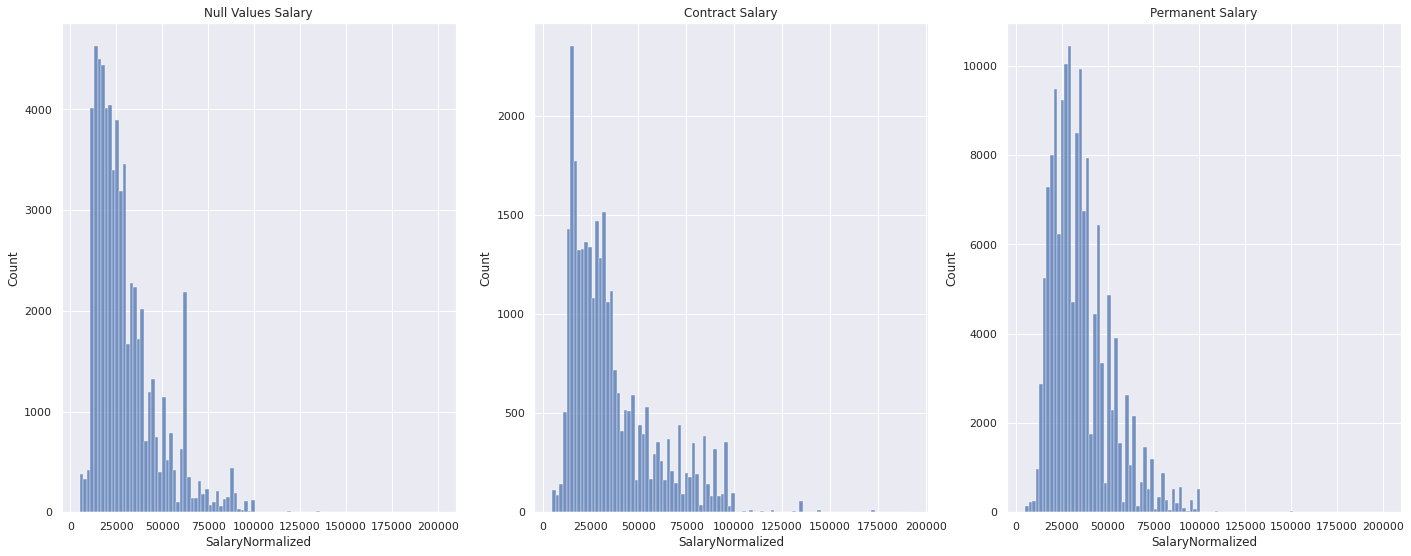

In [162]:
fig, ax = plt.subplots(1, 3)

# plots
sns.histplot(x=null, ax=ax[0], bins=100)
sns.histplot(x=contract, ax=ax[1], bins=100)
sns.histplot(x=permanent, ax=ax[2], bins=100)

# title
ax[0].title.set_text('Null Values Salary')
ax[1].title.set_text('Contract Salary')
ax[2].title.set_text('Permanent Salary')

## 5.4. Title

In [163]:
# Import infos
title_info = pd.read_csv('../data/df_infos_title.csv').drop('Unnamed: 0', axis=1)

# DataFrames Auxiliares
title_corr = title_info[['Word', 'Corr']].sort_values(by='Corr', ascending=False)
title_freq = title_info[['Word', 'Count']].sort_values(by='Count', ascending=False)

# Dicionario de contagem para a nuvem de palavras
dict_freq_title = title_freq.set_index('Word').to_dict()['Count']

<AxesSubplot:title={'center':'Corr Positiva'}, xlabel='Corr', ylabel='Word'>

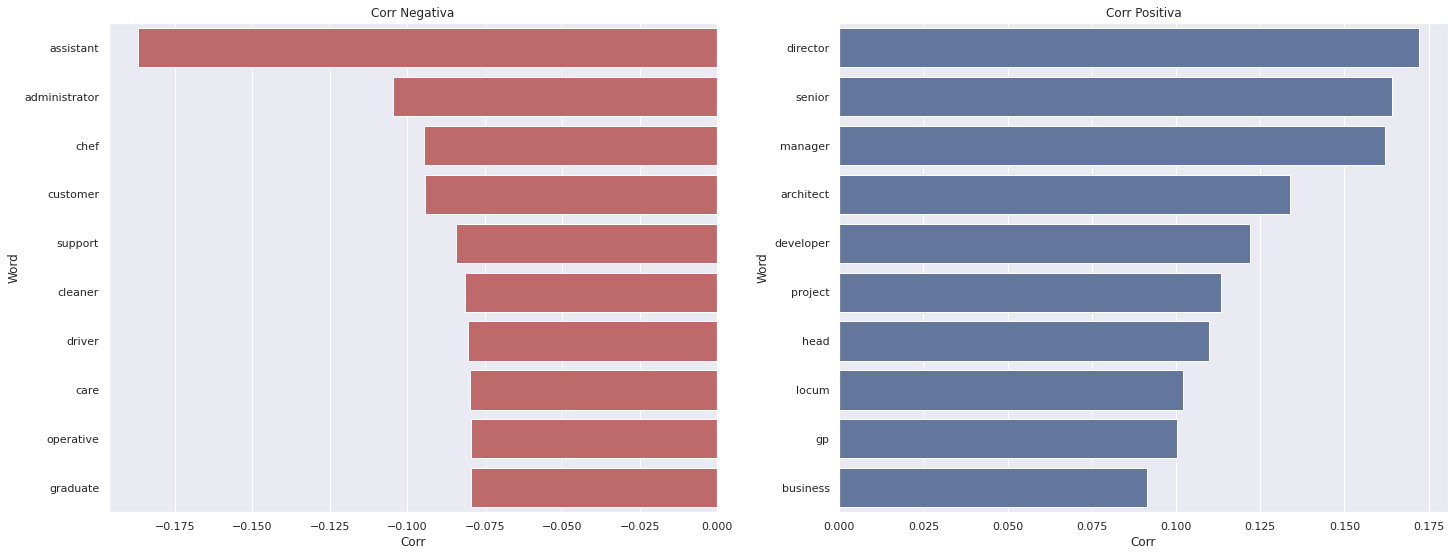

In [164]:
# geranndo os subplots
fig, ax = plt.subplots(1, 2)

# setanto titulos
ax[0].title.set_text('Corr Negativa')
ax[1].title.set_text('Corr Positiva')

# plots
sns.barplot(x='Corr', 
            y='Word', 
            data=title_corr.tail(10).sort_values(by='Corr', ascending=True), 
            color=color_red, ax=ax[0])

sns.barplot(x='Corr', 
            y='Word', 
            data=title_corr.head(10), 
            color=color_blue, ax=ax[1])

(-0.5, 499.5, 499.5, -0.5)

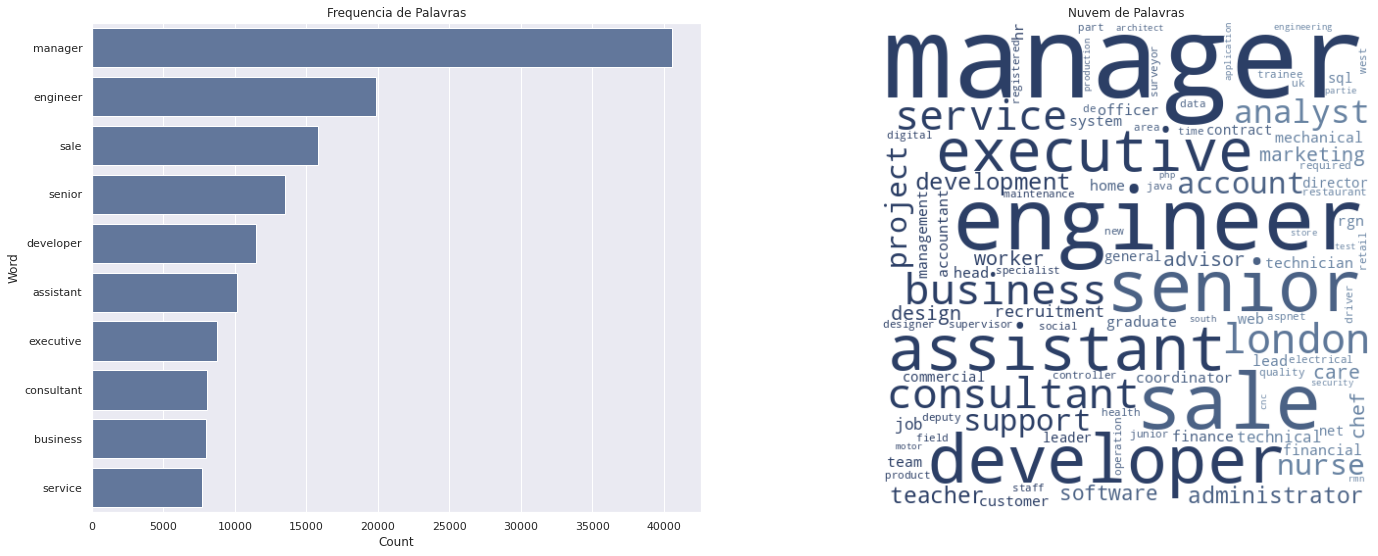

In [165]:
# geranndo os subplots
fig, ax = plt.subplots(1, 2)

# setanto titulos
ax[0].title.set_text('Frequencia de Palavras')
ax[1].title.set_text('Nuvem de Palavras')

# plots
sns.barplot(x='Count', 
            y='Word', 
            data=title_freq.head(10).sort_values(by='Count', ascending=False), 
            color=color_blue, ax=ax[0])


# Nuvem de palavras
# Color mask
mask = np.array(Image.open("../img/blue_palette.png"))

# Instanciando a color mark
image_colors = ImageColorGenerator(mask)

# Configurando a WordCloud
wc = WordCloud(background_color="white", max_words=100,
               max_font_size=256, mode='RGBA',
               random_state=42, width=500, height=500)

# Plot na axis
ax[1] = wc.generate_from_frequencies(dict_freq_title)
imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
axis('off')

## 5.5. Describe

In [166]:
# Import infos
desc_info = pd.read_csv('../data/df_infos_desc.csv').drop('Unnamed: 0', axis=1)

# DataFrames Auxiliares
desc_corr = desc_info[['Word', 'Corr']].sort_values(by='Corr', ascending=False)
desc_freq = desc_info[['Word', 'Count']].sort_values(by='Count', ascending=False)

# Dicionario de contagem para a nuvem de palavras
dict_freq_desc = desc_freq.set_index('Word').to_dict()['Count']

<AxesSubplot:title={'center':'Corr Positiva'}, xlabel='Corr', ylabel='Word'>

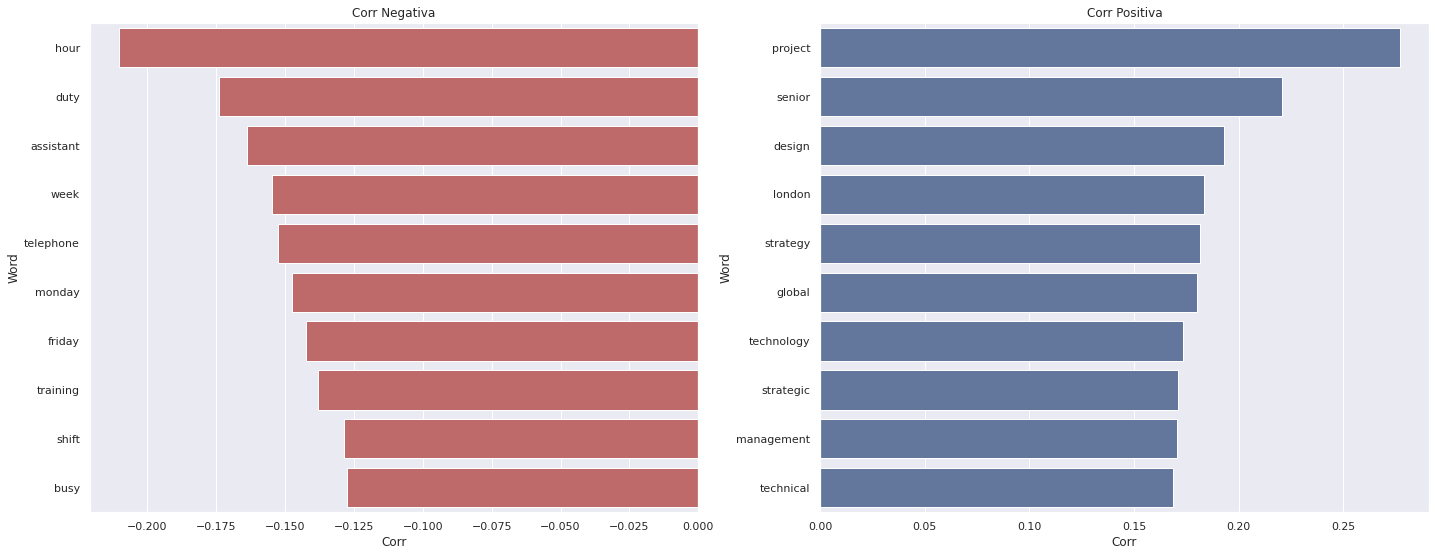

In [167]:
# geranndo os subplots
fig, ax = plt.subplots(1, 2)

# setanto titulos
ax[0].title.set_text('Corr Negativa')
ax[1].title.set_text('Corr Positiva')

# plots
sns.barplot(x='Corr', 
            y='Word', 
            data=desc_corr.tail(10).sort_values(by='Corr', ascending=True), 
            color=color_red, ax=ax[0])

sns.barplot(x='Corr', 
            y='Word', 
            data=desc_corr.head(10), 
            color=color_blue, ax=ax[1])

(-0.5, 499.5, 499.5, -0.5)

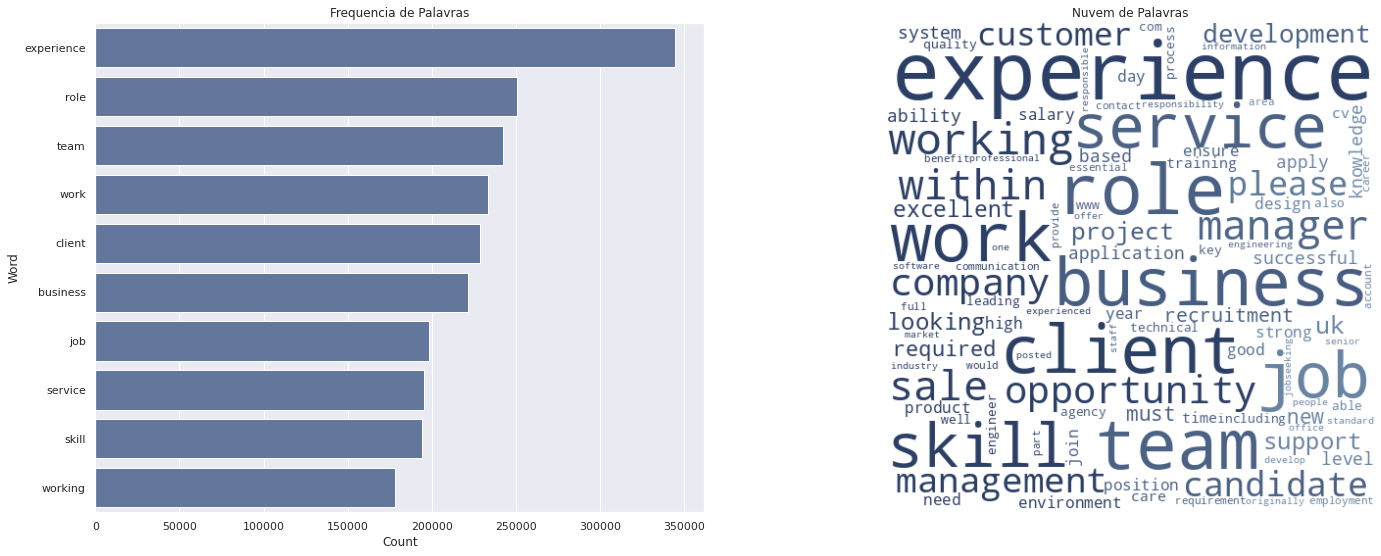

In [168]:
# geranndo os subplots
fig, ax = plt.subplots(1, 2)

# setanto titulos
ax[0].title.set_text('Frequencia de Palavras')
ax[1].title.set_text('Nuvem de Palavras')

# plots
sns.barplot(x='Count', 
            y='Word', 
            data=desc_freq.head(10).sort_values(by='Count', ascending=False), 
            color=color_blue, ax=ax[0])


# Nuvem de palavras
# Color mask
mask = np.array(Image.open("../img/blue_palette.png"))

# Instanciando a color mark
image_colors = ImageColorGenerator(mask)

# Configurando a WordCloud
wc = WordCloud(background_color="white", max_words=100,
               max_font_size=256, mode='RGBA',
               random_state=42, width=500, height=500)

# Plot na axis
ax[1] = wc.generate_from_frequencies(dict_freq_desc)
imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
axis('off')

# 6.0. Data Preparation

In [169]:
X_train_6 = X_train.copy()

## 6.1. Filter

In [171]:
X_train_6 = X_train.drop(['SalaryNormalized', 'Title', 'FullDescription', 'LocationRaw', 'City'], axis=1)

In [172]:
X_train_6.head()

,ContractType,ContractTime,Category
202412,full_time,NaN,IT Jobs
40887,NaN,permanent,Engineering Jobs
103094,NaN,permanent,IT Jobs
162049,NaN,permanent,IT Jobs
121013,NaN,permanent,Other/General Jobs


## 6.2. NA Values

In [173]:
X_train_6.loc[X_train['ContractType'].isnull(), 'ContractType'] = 'full_time'
X_train_6.loc[X_train['ContractTime'].isnull(), 'ContractTime'] = 'permanent'

## 6.3. Categorical

### 6.3.1. One Hot Encoder

In [174]:
trf = ColumnTransformer(transformers =[
    ('enc', OneHotEncoder(sparse = False, drop ='first'), list(range(3))),
], remainder ='passthrough')

In [175]:
X_train_6 = pd.DataFrame(trf.fit_transform(X_train_6))

### 6.2.3. Join Dummies

In [176]:
# Import Dummy Columns
dummy_cols_title = pd.read_csv('../data/dummy_cols_title.csv', index_col=0).reset_index(drop=True)

In [177]:
dummies_city.head(1)

,London,UK,South East England,Aberdeen,The City
202412,0,0,0,0,0


# 7.0. Feature Selection

In [178]:
X_train_t = pd.concat([X_train_6, dummy_cols_title.reset_index(drop=True), dummies_city.reset_index(drop=True)], axis=1)

In [179]:
X_train_t.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,assistant,administrator,chef,customer,support,cleaner,driver,care,operative,graduate,advisor,worker,de,partie,executive,trainee,teaching,sale,part,apprentice,technician,telesales,time,clerk,coordinator,receptionist,labourer,nursery,officer,supervisor,hotel,cleaning,service,ledger,operator,sou,nurse,night,staff,secretary,recruitment,junior,purchase,live,cnc,store,restaurant,rosette,commis,travel,start,temporary,motor,administration,kitchen,immediate,class,assessor,rgn,relief,handler,admin,outbound,hgv,speaking,cook,negotiator,representative,account,cover,setter,call,inbound,teacher,deputy,aa,tip,rmn,catering,payroll,apprenticeship,agent,trade,demi,fundraiser,bar,hour,carer,telephone,registered,fitter,1st,shop,vehicle,domestic,machinist,room,german,job,nvq,letting,welder,school,warehouse,lgv,event,helpdesk,parttime,pastry,food,resourcer,cscs,claim,paralegal,telemarketing,reservation,sen,temp,porter,housekeeper,pub,personal,star,collection,charity,member,picker,machine,domiciliary,flt,centre,collector,female,order,nanny,interviewer,clerical,primary,entry,desk,casual,french,ta,fabricator,maintenance,caretaker,tonne,surrounding,administrative,forklift,turner,car,learning,miller,evening,community,telemarketer,hospitality,pre,six,platform,lync,qa,gas,middleware,u,physician,sc,ssrs,dubai,database,hyperion,governance,performance,sd,fpga,payment,erp,technology,stress,safety,freelance,yr,expert,telco,fico,automation,reward,europe,talent,cleared,vendor,etl,national,city,accountant,unix,speech,naval,quantitative,datawarehouse,tier,ccie,big,commodity,insight,modelling,operational,nav,commissioning,ruby,major,private,auditor,liquidity,functional,actuarial,saas,planner,obiee,pipeline,aspnet,estimator,ui,category,real,build,optometrist,implementation,cloud,storage,ip,citrix,power,joint,greenfield,piping,month,python,migration,tdd,embedded,managing,ee,microsoft,vice,litigation,consultant,regional,ssis,ux,mobility,scrum,social,delivery,strategic,avp,affair,client,construction,practitioner,integration,user,pmo,geologist,vmware,offshore,io,linux,information,fx,contractor,principle,bank,surveyor,analytics,intelligence,pricing,medicine,test,counsel,treasury,sa,analysis,drilling,architecture,consultancy,server,android,transformation,mvc,procurement,consulting,corporate,pd,application,management,ax,digital,specialist,process,engineering,capital,geophysicist,rate,m,hedge,sho,solicitor,wpf,rail,international,cisco,emea,subsea,compliance,operation,actuary,market,crm,change,strategy,reporting,product,audit,quantity,dba,firm,group,oil,regulatory,salaried,quant,sharepoint,technical,derivative,net,data,tax,asset,equity,presales,chief,short,sql,network,dynamic,enterprise,planning,ecommerce,bi,agile,fund,commercial,design,programme,trading,infrastructure,software,interim,vp,system,dentist,contract,development,pqe,investment,associate,oracle,sap,lawyer,banking,principal,uk,global,finance,engineer,solution,analyst,risk,partner,doctor,financial,java,london,lead,business,gp,locum,head,project,developer,architect,manager,senior,director,London,UK,South East England,Aberdeen,The City
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [180]:
X_train_t.columns = [value for value in range(1, len(X_train_t.columns) + 1)]

# 8.0. Machine Learning Pipeline

## 8.1. Baseline - Mean

In [181]:
base = baseline_performance(y_train, 5)

## 8.2. Linear Regression

In [182]:
lr = LinearRegression()

lr_model = cross_val_performance(X_train_t, y_train, cv=5, model=lr)

In [183]:
lr_model

,Modelo,MAE,MAPE,RMSE,time
0,LinearRegression,8590.24,0.2866,12250.84,11.55


## 8.3. DecisionTreeRegressor

In [184]:
dtr = DecisionTreeRegressor()

dtr_model = cross_val_performance(X_train_t, y_train, cv=5, model=dtr)

In [185]:
dtr_model

,Modelo,MAE,MAPE,RMSE,time
0,DecisionTreeRegressor,7661.34,0.2413,12406.35,22.54


## 8.4. Comparance

In [186]:
cross_performance = pd.concat([base, lr_model, dtr_model]).sort_values(by='MAE').reset_index(drop=True)

cross_performance

,Modelo,MAE,MAPE,RMSE,time
0,DecisionTreeRegressor,7661.340,0.2413,12406.350,22.54
1,LinearRegression,8590.240,0.2866,12250.840,11.55
2,Baseline,13404.349,0.4940,17641.462,0.00


In [187]:
# save performance
cross_performance.to_csv('../data/cross_performance_c04_location.csv')

# 9.0. Test Data

In [199]:
title_corr_final = [word for word in dummy_cols_title.columns]

In [200]:
X_test = X_test.loc[:, ['Title', 'LocationRaw', 'LocationNormalized', 'ContractType', 'ContractTime', 'Category']]

In [201]:
# selecionando as 3 colunas iniciais
dums = X_test.loc[:, ['ContractType', 'ContractTime', 'Category']]

# Filtrando null values
dums.loc[dums['ContractType'].isnull(), 'ContractType'] = 'full_time'
dums.loc[dums['ContractTime'].isnull(), 'ContractTime'] = 'permanent'

# Transformando as colunas em binarias
trf = ColumnTransformer(transformers =[
    ('enc', OneHotEncoder(sparse = False, drop ='first'), list(range(3))),
], remainder ='passthrough')

dums = pd.DataFrame(trf.fit_transform(dums))

In [202]:
X_test_t = pd.concat([X_test.loc[:, ['Title', 'LocationRaw', 'LocationNormalized']].reset_index(drop=True), dums], axis=1)

In [203]:
# Tokenizando
X_test_t['Title'] = X_test_t['Title'].apply(lambda x: tokenize(x))

# Transformando os tokens
for value in title_corr_final:
    X_test_t[value] = X_test_t['Title'].apply(lambda x: 1 if value in x else 0)

/tmp/ipykernel_14717/2091902555.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_t[value] = X_test_t['Title'].apply(lambda x: 1 if value in x else 0)


In [206]:
# city
column_new_city = city_imputation(X_test, 'LocationRaw', 'LocationNormalized', city_api_list)

In [216]:
X_test_t = pd.concat([X_test_t, column_new_city.reset_index(drop='True')], axis=1)

In [217]:
df_aux = X_test_t.loc[:, ['City', 'LocationRaw']]

for column in list_corr_city:
    df_aux[column] = df_aux['City'].apply(lambda x: 1 if column == x else 0)

dummies_city = df_aux.drop(['City', 'LocationRaw'], axis=1)

In [219]:
X_test_t = pd.concat([X_test_t, dummies_city], axis=1)

In [222]:
X_test_t = X_test_t.drop(['City', 'LocationRaw', 'LocationNormalized', 'Title'], axis=1)

In [225]:
X_test_t.columns = [value for value in range(1, len(X_test_t.columns) + 1)]

In [226]:
dtr = DecisionTreeRegressor()

dtr.fit(X_train_t, y_train)

DecisionTreeRegressor()

In [227]:
y_hat = dtr.predict(X_test_t)

In [228]:
mean_absolute_error(y_test, y_hat)

7523.998417934531

# 10.0. Deploy